In [24]:
import os
import sys
import numpy as np
from nanowire.optics.simulate import Simulator
from nanowire.optics.postprocess import Simulation
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config
from nanowire.optics.utils.geometry import *
import scipy.integrate as intg
import scipy.constants as consts
import matplotlib.pyplot as plt
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utility Functions

In [42]:
def integrate1d(arr, xvals, meth=intg.trapz):
    x_integral = meth(arr, x=xvals, axis=0)
    return x_integral

def integrate2d(arr, xvals, yvals, meth=intg.trapz):
    x_integral = meth(arr, x=xvals, axis=0)
    y_integral = meth(x_integral, x=yvals, axis=0)
    return y_integral

def integrate3d(arr, xvals, yvals, zvals, meth=intg.trapz):
    ##print("Layer: {}".format(layer_obj.name))
    ##print("Layer Start Ind: {}".format(layer_obj.istart))
    ##print("Layer End Ind: {}".format(layer_obj.iend))
    ##print(z_vals)
    z_integral = meth(arr, x=zvals, axis=0)
    x_integral = meth(z_integral, x=xvals, axis=0)
    y_integral = meth(x_integral, x=yvals, axis=0)
    return y_integral

def compute_fluxes(sim):
    fluxes = sim.data['fluxes']
    total_incident_power = .5*sim.period**2/Zo*np.absolute(fluxes['Air'][0])
    total_reflected_power = .5*sim.period**2/Zo*np.absolute(fluxes['Air'][1])
    total_transmitted_power = .5*sim.period**2/Zo*np.absolute(sum(fluxes['Substrate_bottom']))
    total_absorbed_power = total_incident_power - total_reflected_power - total_transmitted_power
    #print('Total Incident Power = {}'.format(total_incident_power))
    #print('Total Reflected Power = {}'.format(total_reflected_power))
    #print('Total Transmitted Power = {}'.format(total_transmitted_power))
    #print('Total Absorbed Power = {}'.format(total_absorbed_power))
    summed_absorbed_power = 0
    abs_dict_fluxmethod = {}
    for layer, (forw_top, back_top) in fluxes.items():
        if '_bottom' in layer:
            continue
        bottom = layer+'_bottom'
        forw_bot, back_bot = fluxes[bottom] 
        #print('-'*25)
        #print('Layer: {}'.format(layer))
        #print('Forward Top: {}'.format(forw_top))
        #print('Backward Top: {}'.format(back_top))
        #print('Forward Bottom: {}'.format(forw_bot))
        #print('Backward Bottom: {}'.format(back_bot))
        P_in = forw_top + -1*back_bot
        P_out = forw_bot + -1*back_top
        #print('Power Entering Layer: {}'.format(P_in))
        #print('Power Leaving Layer: {}'.format(P_out))
        P_lost = P_in - P_out
        P_abs = .5*P_lost*(sim.period**2)/Zo
        abs_dict_fluxmethod[layer] = P_abs 
        #print('Absorbed in Layer: {}'.format(P_abs))
        summed_absorbed_power += P_abs
    #print('-'*25)
    #print('Summed Absorption= {}'.format(summed_absorbed_power))
    return abs_dict_fluxmethod, summed_absorbed_power

def get_intmethod_abs(sim_proc):
    abs_dict_intmethod = {}
    int_method_total = 0
    freq = sim_proc.conf[("Simulation","params","frequency","value")]
    Esq = sim_proc.normEsquared()
    for layer_name, layer_obj in sim_proc.layers.items():
        #print("Layer: {}".format(layer_name))
        base_unit = sim_proc.conf[('Simulation', 'base_unit')]
        n_mat, k_mat = layer_obj.get_nk_matrix(freq)
        # n and k could be functions of space, so we need to multiply the
        # fields by n and k before integrating
        arr = Esq[layer_obj.slice]
        z_vals = sim_proc.Z[layer_obj.istart:layer_obj.iend]
        res = integrate3d(arr*n_mat*k_mat,sim_proc.X, sim_proc.Y, z_vals)
        if np.isnan(res):
            #print("Result is nan!")
            res = 0
        p_abs_imag = 2*np.pi*freq*consts.epsilon_0*res*base_unit
        abs_dict_intmethod[layer_name] = p_abs_imag
        #disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)
        int_method_total += p_abs_imag
    #print("Integral Method Total Absorption: {}".format(int_method_total))
    return abs_dict_intmethod, int_method_total

def get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total):
    errors = {}
    for key in abs_dict_fluxmethod.keys():
        fm = abs_dict_fluxmethod[key]
        im = abs_dict_intmethod[key]
        diff = np.abs(fm - im)
        try:
            pdiff = 100*diff/fm
        except ZeroDivisionError:
            pdiff = None
            pass
        print('-'*25)
        print("Layer: {}".format(key))
        print("Flux Method: {}".format(fm))
        print("Integral Method: {}".format(im))
        print("Diff: {}".format(diff))
        print("Percent Diff: {}".format(pdiff))
        errors[key] = (diff, pdiff)
    pdiff_total = 100*abs(flux_method_total - int_method_total)/flux_method_total
    print('-'*25)
    print("Total Percent Difference: {}".format(pdiff_total))
    errors['total'] = pdiff_total
    return errors

def get_layer_absorption(sim, layer, plane_samps, zsamps, interp='nknormEsq', meth=intg.trapz):
    layer_results = []
    freq = sim.conf[('Simulation', 'params', 'frequency')]
    base_unit = sim.conf[('Simulation', 'base_unit')]
    period = sim.conf[('Simulation', 'params', 'array_period')]
    layer_obj = sim.layers[layer]
    if interp == 'nknormEsq':
        x = np.linspace(0, period, plane_samps)
        z = np.linspace(layer_obj.start, layer_obj.end, zsamps)
        pts = cartesian_product((z, x, x))
        nkEsq = sim.nknormEsq(pts)
        nkEsq = nkEsq.reshape((zsamps, plane_samps, plane_samps))
        result = integrate3d(nkEsq, x, x, z, meth=meth)
    elif interp == 'normEsq':
        x = np.linspace(0, period, plane_samps)
        n_mat, k_mat = layer_obj.get_nk_matrix(freq, xcoords=x, ycoords=x)
        z = np.linspace(layer_obj.start, layer_obj.end, zsamps)
        pts = cartesian_product((z, x, x))
        Esq = sim.normEsq(pts)
        Esq = Esq.reshape((zsamps, plane_samps, plane_samps))
        result = integrate3d(n_mat*k_mat*Esq, x, x, z, meth=meth)
    elif interp == 'nknormEsqno':
        n_mat, k_mat = layer_obj.get_nk_matrix(freq, xcoords=sim.X, ycoords=sim.Y)
        z = sim.Z[layer_obj.slice]
        Esq = sim.data['nknormEsq'][layer_obj.slice]
        result = integrate3d(Esq, sim.X, sim.Y, z, meth=meth)
    elif interp == 'normEsqno':
        z = sim.Z[layer_obj.slice]
        n_mat, k_mat = layer_obj.get_nk_matrix(freq, xcoords=sim.X, ycoords=sim.Y)
        Esq = sim.data['normEsq'][layer_obj.slice]
        result = integrate3d(n_mat*k_mat*Esq, sim.X, sim.Y, z, meth=meth)
    else:
        raise ValueError('Invalid interp method')
    result = 2*np.pi*freq*consts.epsilon_0*result*base_unit
    print("Done with get_layer_absorption!")
    return result

def cartesian_product(arrays, out=None):
    la = len(arrays)
    L = *map(len, arrays), la
    dtype = np.result_type(*arrays)
    arr = np.empty(L, dtype=dtype)
    arrs = *accumulate(chain((arr,), repeat(0, la-1)), np.ndarray.__getitem__),
    idx = slice(None), *itertools.repeat(None, la-1)
    for i in range(la-1, 0, -1):
        arrs[i][..., i] = arrays[i][idx[:la-i]]
        arrs[i-1][1:] = arrs[i]
    arr[..., 0] = arrays[0][idx]
    return arr.reshape(-1, la)

def integrate_layers(sim, fdict, meth=intg.trapz):
   
    freq = sim.conf[('Simulation', 'params', 'frequency')]
    base_unit = sim.conf[('Simulation', 'base_unit')]
    abs_dict = {}
    total = 0
    for lname, fields in fdict.items():
        layer = sim.layers[lname]
        normEsq = np.abs(fields['Ex'])**2 + np.abs(fields['Ey'])**2 + np.abs(fields['Ez'])**2
        n_mat, k_mat = layer.get_nk_matrix(freq, xcoords=sim.X, ycoords=sim.Y)
        z = np.linspace(layer.start, layer.end, normEsq.shape[0])
        arr = n_mat*k_mat*normEsq 
        #fig, ax = plt.subplots(figsize=(14 ,7))
        #ax.set_title(lname)
        #ax.imshow(arr[:, int(arr.shape[1]/2), :], aspect='equal', extent=[0, .25, z[-1], z[0]])
        #for zv in z:
        #    ax.plot([0, .25], [z,z],'r--')
        #plt.show()
        result = integrate3d(arr, sim.X, sim.Y, z, meth=meth)
        result = 2*np.pi*freq*consts.epsilon_0*result*base_unit
        abs_dict[lname] = result
        total += result
    return abs_dict, total

# Results

In [3]:
!cat interpolator.yml

General:
    
    base_dir: '$HOME/software/nanowire/tests'
    db_name: 'test_run.db'
    base_name: 'field_data'
    postprocess: False
    post_parallel: False
    execution: 'parallel'
    adaptive_convergence: False
    max_iter: 4 
    max_diff: .02
    basis_step: 20
    opt_max_iter: 60
    opt_tol: 1e-4
    func_opt_tol: 1e-4
    opt_keep_intermediates: False
    num_cores: 20
    save_plots: True
    show_plots: False
    save_as: 'hdf5'
    save_time: True
    output_pattern: True
    compute_h: False
    compression: True
    dielectric_profile: False
    solution_file: 'solution.xml'
    x_samples: 300
    y_samples: 300
    z_samples: 300
    r_samples : '`int(%(Simulation.params.array_period)s*200)`'
    theta_samples : 180

Solver:

    Verbosity: 0
    LatticeTruncation: 'Circular'
    DiscretizedEpsilon: False
    DiscretizationResolution: 8
    PolarizationDecomposition: True
    PolarizationBasis: 'Default'
    LanczosSmoothing: False
    SubpixelSmoothing: False
  

In [4]:
conf = Config('interpolator.yml')
#conf['General']['x_samples'] = 200
#conf['General']['y_samples'] = 200
sim = Simulator(conf)
sim.setup()
Zo = consts.physical_constants['characteristic impedance of vacuum'][0]
sim.load_state()

Loading from: /home/kyle_robertson/software/nanowire/tests/4ab4b7e6be/solution.xml


In [5]:
%time sim.get_fluxes()
sim.data['fluxes'] = {record[0].decode():(record[1], record[2]) for record in sim.data['fluxes']}
abs_dict_fluxmethod, flux_method_total = compute_fluxes(sim)
print("######")
%time sim.save_state()

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 83.8 ms
######
CPU times: user 14.4 s, sys: 704 ms, total: 15.1 s
Wall time: 15.4 s


In [14]:
sd = {"Air":5, "ITO":100, "NW_AlShell":300, "Substrate":300}
layer_fields = sim.compute_fields_by_layer(sd)

In [15]:
print(layer_fields['Substrate']['Ex'].shape)

(300, 300, 300)


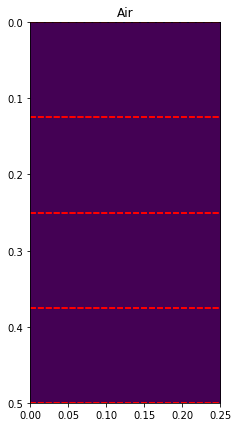

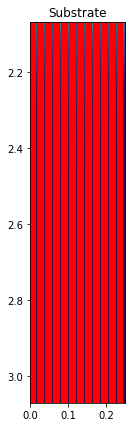

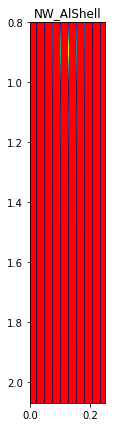

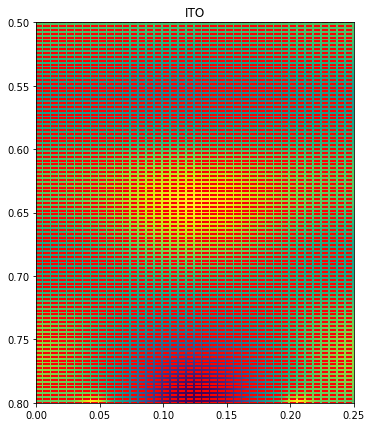

In [39]:
abs_dict_intmethod, int_method_total = integrate_layers(sim, layer_fields, meth=intg.simps)

In [41]:
print(abs_dict_fluxmethod)
print(abs_dict_intmethod)

{'Air': (9.4303897293388858e-18+0j), 'Substrate': (0.0015532646023584853+0j), 'NW_AlShell': (0.056875497259997083+0j), 'ITO': (0.0028263997621786855+0j)}
{'Air': 0.0, 'Substrate': 0.0015682105315748733, 'NW_AlShell': 0.058108625144707285, 'ITO': 0.0028286755733314822}


In [43]:
errs = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)

-------------------------
Layer: Air
Flux Method: (9.430389729338886e-18+0j)
Integral Method: 0.0
Diff: 9.430389729338886e-18
Percent Diff: (100+0j)
-------------------------
Layer: Substrate
Flux Method: (0.0015532646023584853+0j)
Integral Method: 0.0015682105315748733
Diff: 1.4945929216388012e-05
Percent Diff: (0.9622268603619778+0j)
-------------------------
Layer: NW_AlShell
Flux Method: (0.05687549725999708+0j)
Integral Method: 0.058108625144707285
Diff: 0.0012331278847102015
Percent Diff: (2.1681179842229037+0j)
-------------------------
Layer: ITO
Flux Method: (0.0028263997621786855+0j)
Integral Method: 0.0028286755733314822
Diff: 2.2758111527967743e-06
Percent Diff: (0.08051978999044712+0j)
-------------------------
Total Percent Difference: (2.0412151268875025+0j)


In [19]:
abs_dict_intmethod, int_method_total = integrate_layers(sim, layer_fields, meth=intg.trapz)

In [20]:
print(abs_dict_fluxmethod)
print(abs_dict_intmethod)

{'Air': (9.4303897293388858e-18+0j), 'Substrate': (0.0015532646023584853+0j), 'NW_AlShell': (0.056875497259997083+0j), 'ITO': (0.0028263997621786855+0j)}
{'Air': 0.0, 'Substrate': 0.0015696042886096616, 'NW_AlShell': 0.058114612834832782, 'ITO': 0.0028287105066401395}


In [21]:
errs = get_errors(abs_dict_intmethod, abs_dict_fluxmethod, int_method_total, flux_method_total)

-------------------------
Layer: Air
Flux Method: (9.430389729338886e-18+0j)
Integral Method: 0.0
Diff: 9.430389729338886e-18
Percent Diff: (100+0j)
-------------------------
Layer: Substrate
Flux Method: (0.0015532646023584853+0j)
Integral Method: 0.0015696042886096616
Diff: -1.6339686251176308e-05
Percent Diff: (1.051957678451311+0j)
-------------------------
Layer: NW_AlShell
Flux Method: (0.05687549725999708+0j)
Integral Method: 0.05811461283483278
Diff: -0.0012391155748356988
Percent Diff: (2.1786456989928085+0j)
-------------------------
Layer: ITO
Flux Method: (0.0028263997621786855+0j)
Integral Method: 0.0028287105066401395
Diff: -2.310744461454014e-06
Percent Diff: (0.0817557548785248+0j)
-------------------------
Total Percent Difference: (2.0533224828592154+0j)
